In [2]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
from argparse import Namespace

from GeospatialFM.datasets.GFMBench.utils import get_dataset, get_metadata
from GeospatialFM.data_process import apply_normalization, modal_specific_collate_fn, get_transform
from GeospatialFM.finetune.utils import get_task_model, get_loss_fn
from GeospatialFM.finetune.args import parse_args
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.finetune.linear_probe import compute_encoding

from functools import partial
from accelerate import Accelerator
from transformers import TrainingArguments
from safetensors import safe_open

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json
from sklearn.decomposition import PCA
import cv2

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def pca_vis_patch(patch, n_components=3):
    # perform PCA on patch
    pca = PCA(n_components=n_components)
    B, L, D = patch.shape
    patch_ = patch.reshape(B*L, D)
    try:
        patch_ = patch_.cpu().numpy()
    except:
        pass
    pca.fit(patch_)
    patch_pca = pca.transform(patch_)

    preprocessed_patches = patch_pca.reshape(B, int(L**0.5), int(L**0.5), 3)
    return preprocessed_patches

def norm_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

In [4]:
ROOT_DIR="/home/haozhesi/Dropbox/GeospatialFM"

In [5]:
args = parse_args([
    # "--data_dir", ROOT_DIR + "/data/geospatial-2",
    "--data_dir", "/data-4/common/geospatial",
    "--dataset_name", "bigearthnet",
    "--task_type", "multilabel", 
    "--scale", "2",
    "--modal", "multi",
    "--return_dict",
    "--per_device_train_batch_size", "64",
    "--gradient_accumulation_steps", "4", 
    "--num_train_epochs", "20",
    "--learning_rate", "3e-4",
    "--adam_weight_decay", "0.01",
    "--warmup_steps", "0",
    "--warmup_ratio", "0.2",
    "--report_to", "wandb",
    "--save_total_limit", "5",
    "--seed", "42",
    "--mixed_precision", "bf16",
    "--dataloader_num_workers", "32",
    "--dataloader_pin_memory",
    "--output_dir", ROOT_DIR + "/results/models",
    "--logging_dir", ROOT_DIR + "/results/logs", 
    "--wandb_dir", ROOT_DIR + "/results/",
    "--run_name", "LESSVIT_b2_d4_eurosat",
    "--lr_scheduler_type", "cosine",
    "--channel_embed_dims_per_head", "2",
    "--use_perception_field_mask",
    "--use_moe",
    "--num_experts", "3"
])

In [6]:
metadata = get_metadata(args.dataset_name)
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]
print(optical_mean, radar_mean)
print(optical_std, radar_std)
print(metadata["size"], metadata['num_classes'])

[752.40087073, 884.29673756, 1144.16202635, 1297.47289228, 1624.90992062, 2194.6423161, 2422.21248945, 2517.76053101, 2581.64687018, 2645.51888987, 2368.51236873, 1805.06846033] [-12.54847273, -20.19237134]
[1108.02887453, 1155.15170768, 1183.6292542, 1368.11351514, 1370.265037, 1355.55390699, 1416.51487101, 1474.78900051, 1439.3086061, 1582.28010962, 1455.52084939, 1343.48379601] [5.25697717, 5.91150917]
120 19


In [7]:
collate_fn = partial(modal_specific_collate_fn, modal=args.modal)

In [8]:
crop_size = metadata["size"] if args.crop_size is None else args.crop_size
train_transform, eval_transform = get_transform(args.task_type, crop_size=crop_size, scale=args.scale, 
                                                 optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std)

In [9]:
dataset = get_dataset(args, train_transform, eval_transform)

BigEarthNetConfig: data_dir=/data-4/common/geospatial, pad_s2=False, bands=all, num_classes=19 

BigEarthNetConfig: data_dir=/data-4/common/geospatial, pad_s2=False, bands=all, num_classes=19 

BigEarthNetConfig: data_dir=/data-4/common/geospatial, pad_s2=False, bands=all, num_classes=19 



torch.Size([240, 240, 3])
torch.Size([240, 240, 3])
torch.Size([240, 240, 3])
torch.Size([240, 240, 3])


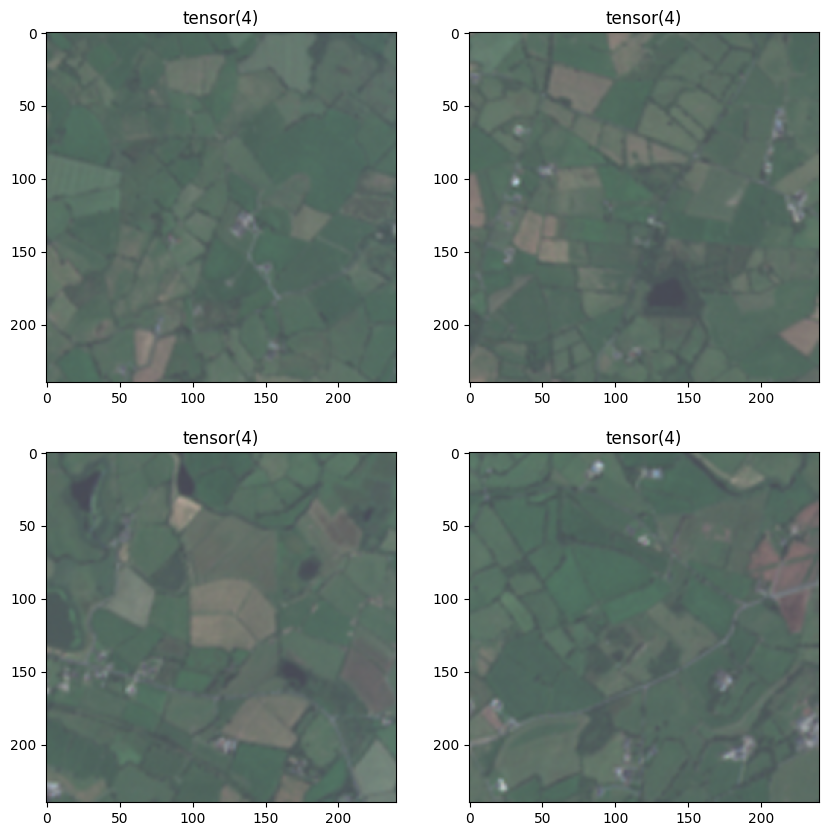

In [10]:
# visualize the dataset via matplotlib
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(dataset["train"][i]['optical'][[3, 2, 1], :, :].permute(1, 2, 0))
    print(dataset["train"][i]['optical'][[3, 2, 1], :, :].permute(1, 2, 0).shape)
    # plt.title(dataset["train"][i]['label'])
    plt.title(torch.argmax(torch.tensor(dataset["train"][i]['label'])))
    # print(torch.max(dataset["train"][i]['optical']))
plt.show()

In [11]:
dataloader = DataLoader(dataset["val"], batch_size=4, collate_fn=collate_fn)
for i, batch in enumerate(dataloader):
    # print(batch['optical'].shape)
    for key, value in batch.items():
        print(key, value.shape)
    break
labels = batch.pop("labels")

spatial_resolution ()
labels torch.Size([4, 19])
optical torch.Size([4, 12, 240, 240])
optical_channel_wv torch.Size([1, 12])
radar torch.Size([4, 2, 240, 240])
radar_channel_wv torch.Size([1, 2])


In [12]:
# model = get_task_model(args, metadata["num_classes"], metadata["size"])
# if args.pretrained_model_path:
#         from safetensors import safe_open
#         with safe_open(args.pretrained_model_path, framework="pt", device="cpu") as f:
#             # Load only encoder weights
#             for key in f.keys():
#                 if key.startswith("encoder."):
#                     # Get the corresponding key in target model
#                     param = f.get_tensor(key)
#                     model.state_dict()[key].copy_(param)

In [13]:
# outputs = model.encoder(**batch)

In [14]:
# outputs["last_hidden_state"].shape

In [15]:
# loss_fn = get_loss_fn(args.task_type)

In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    channel_embed_dims_per_head=1,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    decoder_channel_embed_dims_per_head=1,
    use_perception_field_mask=True,
    attention_radius=320,
    norm_pix_loss=False,
    decoder_out_chans = 15,
    pos_chan_embed_residual=True,
)

# Initialize model
model = SpatialSpectralMAEViT(config)

In [17]:
# Set model to training mode
device = 'cuda:1'
model.to(device, dtype=torch.bfloat16)
model.train()
print()

In [18]:
with safe_open("/home/haozhesi/Dropbox/GeospatialFM/results/models/LESSVIT_b1_d8/checkpoint-50000/model.safetensors", framework="pt", device=device) as f:
    state_dict = {key: f.get_tensor(key) for key in f.keys()}

# Load the state dict into the model
model.load_state_dict(state_dict)
print("Model loaded successfully from safetensors file.")

Model loaded successfully from safetensors file.


In [19]:
batch.keys()

dict_keys(['spatial_resolution', 'optical', 'optical_channel_wv', 'radar', 'radar_channel_wv'])

In [20]:
batch = next(iter(dataloader))
optical = batch['optical'].to(device, dtype=torch.bfloat16)
# radar = batch['radar'].to(device, dtype=torch.bfloat16)
radar = None
optical_channel_wv = batch['optical_channel_wv']
radar_channel_wv = None
spatial_resolution = batch['spatial_resolution']

In [21]:
dataloader = DataLoader(dataset["train"], batch_size=16, collate_fn=collate_fn, shuffle=True)
model.eval()
optical_hidden_states_all = []
radar_hidden_states_all = []
multi_modal_hidden_states_all = []
rgb_images = []
for i, batch in enumerate(tqdm(dataloader)):
    optical = batch['optical'].to(device, dtype=torch.bfloat16)
    radar = batch['radar'].to(device, dtype=torch.bfloat16)
    optical_channel_wv = batch['optical_channel_wv']
    radar_channel_wv = batch['radar_channel_wv']
    spatial_resolution = batch['spatial_resolution']
    rgb_images.append(optical[:, [3, 2, 1], :, :].permute(0, 2, 3, 1).to(torch.float32).detach().cpu().numpy())
    with torch.no_grad():
        _, _, _, multi_modal_hidden_states = model.encoder(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
        # x, cls_token, patch_tokens = x.to(torch.float32).detach().cpu(), cls_token.to(torch.float32).detach().cpu(), patch_tokens.to(torch.float32).detach().cpu()
        multi_modal_hidden_states_all.append(multi_modal_hidden_states[-1])
        
        _, _, _, optical_hidden_states = model.encoder(optical=optical, radar=None, optical_channel_wv=optical_channel_wv, radar_channel_wv=None, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
        optical_hidden_states_all.append(optical_hidden_states[-1])
        _, _, _, radar_hidden_states = model.encoder(optical=None, radar=radar, optical_channel_wv=None, radar_channel_wv=radar_channel_wv, 
                                                                    spatial_resolution=spatial_resolution, mask_ratio=0, channel_mask_ratio=0.)
        radar_hidden_states_all.append(radar_hidden_states[-1])
    if i == 31:
        break
multi_modal_hidden_states_all = torch.cat(multi_modal_hidden_states_all, dim=0)
optical_hidden_states_all = torch.cat(optical_hidden_states_all, dim=0)
radar_hidden_states_all = torch.cat(radar_hidden_states_all, dim=0)
rgb_images = np.concatenate(rgb_images, axis=0)
multi_modal_hidden_states_all.shape, optical_hidden_states_all.shape, radar_hidden_states_all.shape, rgb_images.shape

  0%|          | 31/16856 [01:38<14:51:18,  3.18s/it]


(torch.Size([512, 15, 226, 768]),
 torch.Size([512, 13, 226, 768]),
 torch.Size([512, 3, 226, 768]),
 (512, 240, 240, 3))

In [22]:
multi_modal_hidden_state = multi_modal_hidden_states_all.to(torch.float32)
multi_modal_patches = multi_modal_hidden_state[:, 0, 1:]
multi_modal_pca_patches = pca_vis_patch(multi_modal_patches.numpy())


optical_hidden_states_all = optical_hidden_states_all.to(torch.float32)
optical_patches = optical_hidden_states_all[:, 0, 1:]
optical_pca_patches = pca_vis_patch(optical_patches.numpy())

radar_hidden_states_all = radar_hidden_states_all.to(torch.float32)
radar_patches = radar_hidden_states_all[:, 0, 1:]
radar_pca_patches = pca_vis_patch(radar_patches.numpy())

In [23]:
# mpl.rcParams['axes.titlesize'] = 12

# # fig, ax = plt.subplots(4, 7, figsize=(18, 11))

# # sample_idices = [272, 362, 21, 396, 135, 446,]
# # sample_idices = [57, 272, 52, 205, 4, 322, 106, 147, 178, 488, 396, 135, 446, 21, 232, 362]
# sample_idices = np.random.choice(range(len(rgb_images)), 10)
# print(sample_idices)

# for i, sample_idx in enumerate(sample_idices):
#     fig, ax = plt.subplots(1, 4, figsize=(16, 4))
#     sample_img = rgb_images[sample_idx]
#     sample_img = norm_image(sample_img)

#     # pca_img = processed_patches[sample_idx]
#     pca_img = optical_pca_patches[sample_idx]
#     # resize the image to 224x224
#     pca_img = cv2.resize(pca_img, sample_img.shape[:2], interpolation=cv2.INTER_CUBIC)
#     pca_img = norm_image(pca_img)

#     pca_radar = radar_pca_patches[sample_idx]
#     pca_radar = cv2.resize(pca_radar, sample_img.shape[:2], interpolation=cv2.INTER_CUBIC)
#     pca_radar = norm_image(pca_radar)

#     pca_mm = multi_modal_pca_patches[sample_idx]
#     pca_mm = cv2.resize(pca_mm, sample_img.shape[:2], interpolation=cv2.INTER_CUBIC)
#     pca_mm = norm_image(pca_mm)
    
#     ax[0].imshow(sample_img)
#     ax[1].imshow(pca_img)
#     ax[2].imshow(pca_radar)
#     ax[3].imshow(pca_mm)
    
#     ax[0].set_axis_off()
#     ax[1].set_axis_off()
#     ax[2].set_axis_off()
#     ax[3].set_axis_off()

#     # add title
#     # fig.suptitle(exp_name, fontsize=16)
#     plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the spacing between subplots
#     plt.tight_layout(pad=0)  # Remove padding around the figure
#     # plt.savefig(f"vis_feature_{i}.pdf", bbox_inches='tight', pad_inches=0)

In [26]:
model.train()
for i, batch in enumerate(tqdm(dataloader)):
    optical = batch['optical'].to(device, dtype=torch.bfloat16)
    radar = batch['radar'].to(device, dtype=torch.bfloat16)
    optical_channel_wv = batch['optical_channel_wv']
    radar_channel_wv = batch['radar_channel_wv']
    spatial_resolution = batch['spatial_resolution']
    with torch.no_grad():
        output = model(optical=optical, radar=radar, optical_channel_wv=optical_channel_wv, radar_channel_wv=radar_channel_wv, spatial_resolution=spatial_resolution, mask_ratio=0.75, channel_mask_ratio=0.5)
    break

  0%|          | 0/16856 [00:00<?, ?it/s]

torch.Size([16, 12, 240, 240])


  0%|          | 0/16856 [00:01<?, ?it/s]


IndexError: index 14 is out of bounds for dimension 1 with size 14

: 

In [ ]:
# visualize the reconstruction of every channel of every modality
vis_idx = 4
fig, axs = plt.subplots(4, 15, figsize=(20, 6))
target_img = model.decoder.unpatchify(output['target'])[vis_idx].detach().cpu().to(torch.float32).numpy()
for i in range(15):
    axs[0, i].imshow(target_img[i])
    axs[0, i].axis('off')
for j, modal in enumerate(['optical', 'radar', 'multi']):
    spatial_mask = output[f'{modal}_pos_mask']
    masked_patches = output[f'{modal}_recon'] * spatial_mask.unsqueeze(1).unsqueeze(-1).expand_as(output[f'{modal}_recon'])
    unmasked_patches = output['target'] * (1-spatial_mask).unsqueeze(1).unsqueeze(-1).expand_as(output['target'])
    
    masked_channel_img = model.decoder.unpatchify(output[f'{modal}_recon'])[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_img = model.decoder.unpatchify(masked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    unmasked_img = model.decoder.unpatchify(unmasked_patches)[vis_idx].detach().cpu().to(torch.float32).numpy()
    masked_pos_img = unmasked_img + masked_img
    
    channel_mask = output[f'{modal}_channel_mask'][vis_idx].detach().cpu().to(torch.bool).numpy()
    for i in range(15):
        if channel_mask[i]:
            axs[j+1, i].imshow(masked_channel_img[i])
            axs[j+1, i].axis('off')
            axs[j+1, i].set_title('masked')
        else:
            # axs[j+1, i].imshow(masked_pos_img[i])
            axs[j+1, i].imshow(masked_channel_img[i])
            # axs[j+1, i].imshow(masked_img[i]) 
            axs[j+1, i].axis('off')
plt.show()